# Geoinformática - Práctica 5
## Autocorrelación Espacial y Análisis Exploratorio de Datos Espaciales

La *Autocorrelación Espacial* se relaciona con el grado en el que la similitud de valores entre observaciones de un conjunto de datos se conecta con la similitud en la localización de dichas observaciones. De forma muy semejante a como ocurre con la Correlación Tradicional (que determina cómo los valores de una variable cambian en función de los valores de otra) y de forma análoga a su homólogo en una serie temporal (que relaciona el valor de una variable en algún punto del tiempo con los valores en periodos anteriores), la Autocorrelación Espacial relaciona los valores de la variable de interés en un lugar dado con los valores de ella misma en sus alrededores.

Una idea clave dentro de este contexto es el de *Aleatoriedad Espacial*, esto es, una situación en la cual la ubicación de una observación no guarda relación alguna con el valor de una variable; en otras palabras, una variable es aleatoria espacialmente si la distribución que sigue en el espacio parece no tener algún patrón discernible. Como tal, la *Autocorrelación Espacial* puede ser definida formalmente como la "absencia de Aleatoriedad Espacial", y, al igual que con la correlación tradicional, puede presentarse en dos variaciones:

* *Correlación Espacial Positiva* - Donde los valores similares tienden a agruparse entre sí en ubicaciones similares.
* *Correlación Espacial Negativa* - Donde los valores similares tienden a estar dispersos y alejados entre sí.

En esta práctica, se aprenderá a explorar la Autocorrelación Espacial de un conjunto de datos determinado, analizando la presencia, naturaleza y robustez de los datos utilizados. Para esto, se utilizará un conjunto de herramientas colectivamente conocidos como *Análisis Exploratorio de Datos Espaciales* (ESDA, por sus siglas en inglés), diseñado específicamente para este propósito. El alcance de los Métodos ESDA es bastante amplio y abarca desde aproximaciones sencilllas, como Coropletas (Choropleths) y Consultas a Bases de Datos, hasta metodologías más avanzadas y robustas, como la Inferencia Estadística y la Identificación de la Dimensión Geográfica de los Datos. El propósito de esta sesión es explorar más a detalle estas últimas técnicas.

Los Métodos ESDA comúnmente se dividen en dos grupos principales: herramientas para analizar a la autocorrelación espacial a nivel *global*, y otras a nivel *local*. Las primeras consideran el patrón general que sigue la localización de los valores, y hacen posible realizar conclusiones sobre el grado de Agrupamiento (*Clustering*) que siguen los datos; pueden responderse preguntas como *¿Los valores en general siguen un patrón en particular en su distribución geográfica?* o *¿Los valores similares se encuentran más cerca de lo que se encontrarían en una distribución aleatoria?*. Se analizará la Autocorrelación Espacial Global utilizando el estadístico de *I de Moran*.

Los métodos utilizados para la Autocorrelación Espacial *Local* se enfocan en la inestabilidad espacial, esto es, que tanto se alejan ciertas ubicaciones en particular del patrón general; la idea detrás de esto es que, aún cuando existe un patrón general en términos de la naturaleza y robustez de la asociación espacial, algunas áreas en particular pueden divergir sustancialmente de éste mismo. Sin importar el grado general de concentración de los valores, existen focos donde valores inusualmente altos (o bajos) se encuentran cercanos a otros valores altos (o bajos), zonas que son conocidas como *Hotspots* (o *Coldspots*, para valores bajos); además, también es posible observar valores muy altos rodeados de valores muy bajos (o viceversa), los cuales reciben el nombre de *Outliers Espaciales* (Valores Atípicos). La ténica principal que se utilizará en esta sesión para explorar la Autocorrelación Espacial Local serán los *Indicadores Locales de Asociación Espacial* (LISA, por sus siglas en inglés).

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import libpysal as pss
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import mapclassify

np.random.seed(123)

## Datos
En esta práctica, se continuarán utilizando las AGEB's como unidad espacial, así como la variable de Personas sin Derechohabiencia a Servicios Públic de Salud colectada por el  Consejo Nacional de Evaluación de Política del Desarrollo Social ([CONEVAL](https://www.coneval.org.mx/Medicion/IRS/Paginas/Rezago_social_AGEB_2010.aspx)) en 2010.

Como es de costumbre, se creará una variable que contenga la ruta donde se encuentran los datos a utilizar:

In [2]:
f = 'data/'

## Importando y Analizando los Datos
Como se ha hecho siempre, se utiliza `GeoPandas` para importar e inspeccionar los datos espaciales de la práctica:

<AxesSubplot:>

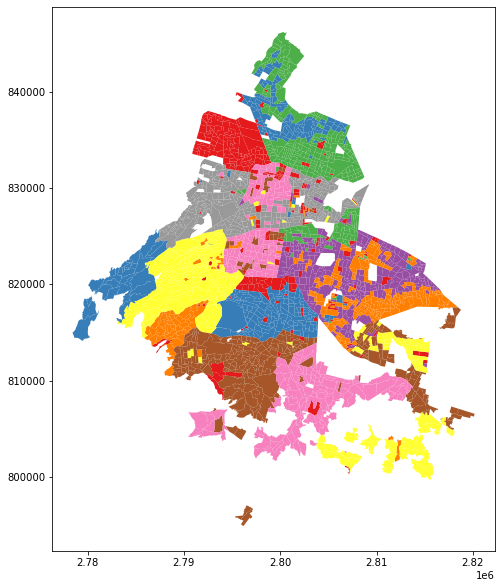

In [3]:
# Importar el ShapeFile
agebs = gpd.read_file(f + 'pob_sinderechohab.shp')

# Asignar como índice de las tablas la Clave Geográfica
agebs = agebs.set_index('cvegeo')

# Graficar el GeoDataFrame
agebs.plot(cmap = 'Set1', figsize = (10,10))

Debido a su naturaleza de `GeoDataFrame`, también es posible inspeccionar su contenido a través de la función `.head()`:

In [4]:
agebs.head()

,alcaldia,p_sderech,p_nescu,p_hacin,p_analf,geometry
cvegeo,,,,,,
0900700013628,09007,389.0,475.0,0.0,9.0,"POLYGON ((2810132.372 824698.172, 2810169.540 ..."
0901500010235,09015,323.0,481.0,6.0,7.0,"POLYGON ((2798881.634 831643.241, 2798843.076 ..."
0900200010097,09002,448.0,780.0,5.0,37.0,"POLYGON ((2792415.239 836846.390, 2792356.808 ..."
0900200011184,09002,240.0,389.0,0.0,11.0,"POLYGON ((2792260.139 836768.777, 2792333.695 ..."
0900300011285,09003,1017.0,1291.0,0.0,23.0,"POLYGON ((2802121.600 817466.682, 2802124.157 ..."


Antes de continuar con la parte analítica, resulta pertinente crear un Mapa de Coropletas para, de entrada, tener una idea visual de cómo es que se distribuye la variable en el espacio. A continuación, se muestra el código necesario para construir este mapa, en el cual cabe resaltar el uso del argumento `scheme` dentro de la función `.plot()` para indicar cómo deben de ser clasificados los datos, para después asignarles el color correspondiente:

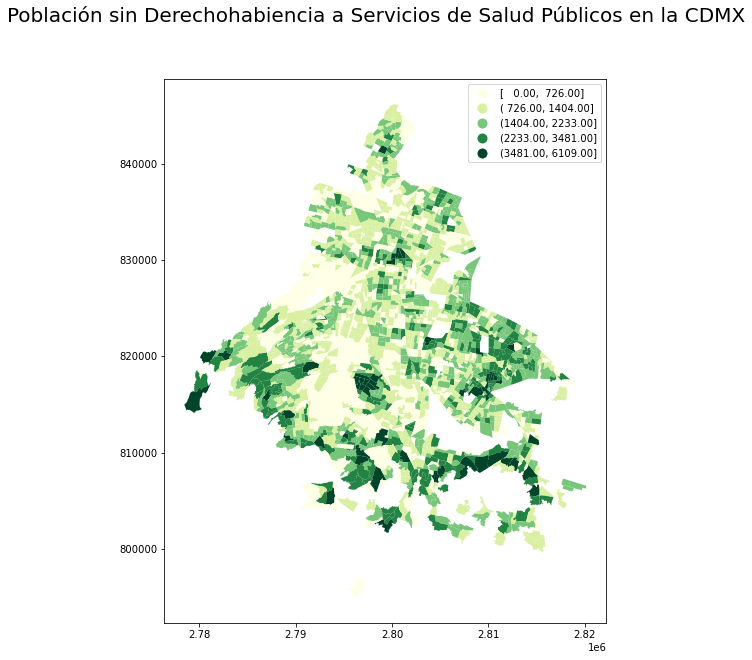

In [5]:
# Preparación de la figura y sus filas
fig , filas = plt.subplots(1, figsize = (10,10))

# Gráfica del GeoDataFrame, generando un Mapa de Coropletas a través de 'scheme'
agebs.plot(ax = filas, column = 'p_sderech', scheme = 'fisherjenks' , cmap = 'YlGn', legend = True)

# Adición de título a la gráfica
fig.suptitle('Población sin Derechohabiencia a Servicios de Salud Públicos en la CDMX', size = 20)

# Mostrar la gráfica
plt.show()

#### Ejercicio Opcional
Crea un mapa similar al anterior, pero utilizando como Métodos de Clasificación los Cuantiles (`quantiles`) e Intervalor Iguales (`equalinterval`), y responde las preguntas: ¿En qué difieren los mapas generados? ¿Cómo varía la interpretación de lo observado en cada uno de los casos? ¿Cuál es la distribución de los datos? Confirma esta última respuesta generando un Diagrama de Densidad de Kernal o un Histograma.

#### Solución

Grafico usando quantiles como metodo de clasificación

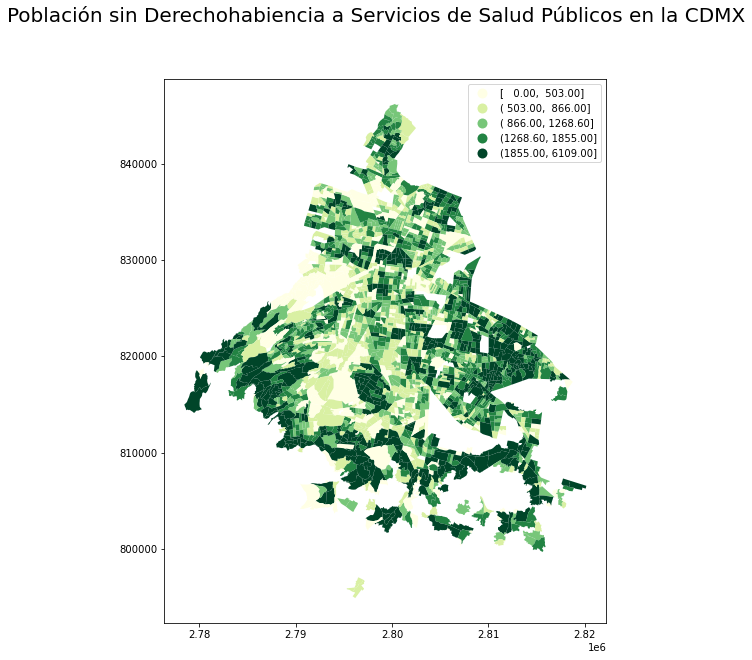

In [6]:
# Preparación de la figura y sus filas
fig , filas = plt.subplots(1, figsize = (10,10))

# Gráfica del GeoDataFrame, generando un Mapa de Coropletas a través de 'scheme'
agebs.plot(ax = filas, column = 'p_sderech', scheme = 'quantiles' , cmap = 'YlGn', legend = True)

# Adición de título a la gráfica
fig.suptitle('Población sin Derechohabiencia a Servicios de Salud Públicos en la CDMX', size = 20)

# Mostrar la gráfica
plt.show()

Grafico usando equalinterval como metodo de clasificación

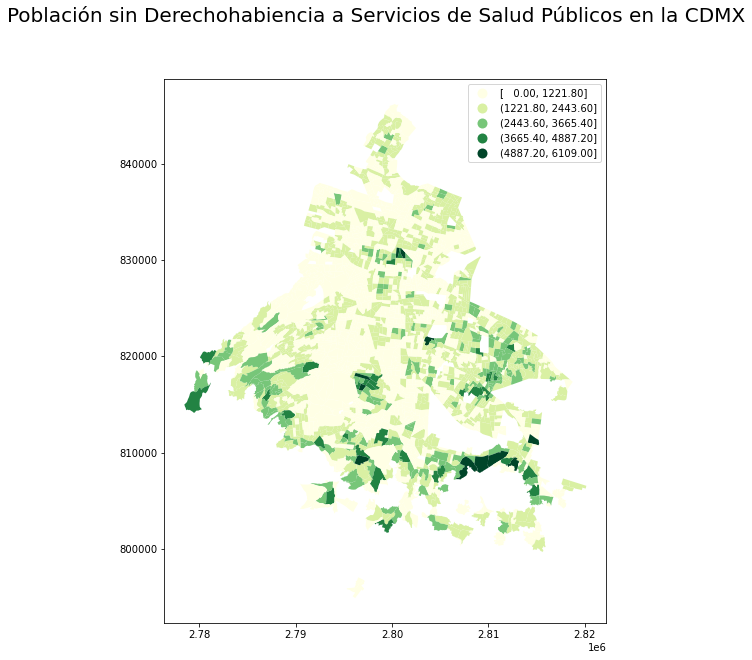

In [7]:
# Preparación de la figura y sus filas
fig , filas = plt.subplots(1, figsize = (10,10))

# Gráfica del GeoDataFrame, generando un Mapa de Coropletas a través de 'scheme'
agebs.plot(ax = filas, column = 'p_sderech', scheme = 'equalinterval' , cmap = 'YlGn', legend = True)

# Adición de título a la gráfica
fig.suptitle('Población sin Derechohabiencia a Servicios de Salud Públicos en la CDMX', size = 20)

# Mostrar la gráfica
plt.show()

##### ¿En qué difieren los mapas generados? 
En el primero la clasificación tiene rangos más pequeños al comienzo y mayores al final, por lo que de verde más oscuro tenemos más elemento, mientras que el grafico por clasificación de rangos iguales tiene los rangos del mismo tamaño.
Para este caso eso impacta en el numero de elementos por grupo
##### ¿Cómo varía la interpretación de lo observado en cada uno de los casos? 
Yo interpretaria que el ultimo grafico nos habla de como los elementos no estan equi repartidos en el rango mientras que en el grafico por cualtiles nos mostraria que elementos caen en el primer y ultimo cualtil y que tan atipicos son estos datos.
##### ¿Cuál es la distribución de los datos? Confirma esta última respuesta generando un Diagrama de Densidad de Kernal o un Histograma.
En el grafico de abajo podemos ver que la interpretación del grafico 2 de equalinterval es correcta, los datos estan sesgados hacia un lado.

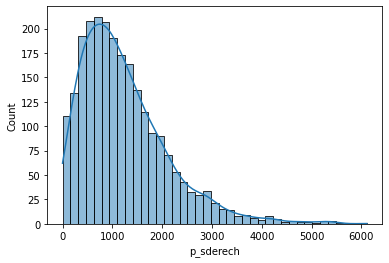

In [8]:
_=sns.histplot(x=agebs['p_sderech'],kde=True,)

___
## Matriz de Pesos Espaciales
Como se ha discutido anteriormente, una Matriz de Pesos Espaciales es la forma en la que el espacio geográfico es codificado de forma numérica, a modo de que sea fácil para una computadora (o un método estadístico) el interpretarlo. Se han estudiado algunas de las varias formas conceptuales en las que puede definirse una Matriz de Pesos Espaciales, como los criterios de *Contigüidad*, *Basados en Distancia*, o de *Bloques*.

En este caso, se utilizará uno de los criterios más comúnes en este tipo de análisis: la Matriz de Contigüidad de Reina:

In [9]:
m_reina = pss.weights.Queen.from_shapefile(f + 'pob_sinderechohab.shp', idVariable = 'cvegeo')
m_reina.transform = 'R'

('WARNING: ', '090090015012A', ' is an island (no neighbors)')


C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There is 1 island with id: 090090015012A.
  warnings.warn(message)


Cabe recordar que, al modificar el parámetro `transform` de la matriz, los valores de los pesos asignados se alteran; por ejemplo, al modificar este parámetro por `'R'`, se han estandarizado los pesos de modo que la suma de éstos sea igual a uno:

In [10]:
m_reina['090150001056A']

{'0901500010610': 0.25,
 '0901500010502': 0.25,
 '0901500010517': 0.25,
 '0901500010574': 0.25}

___
## Rezago Espacial
Una vez que se encuentran listos los datos y la Matriz de Pesos Espaciales, es posible calcular el Rezago Espacial de la variable `p_sderech`. Importante recordar que el rezago espacial es el resultado del producto entre la Matriz de Pesos Espaciales y una variable dada y que, si $W$ se encuentra estandarizada en filas, los resultados equivalen al valor promedio de una variable en la vecidad de una observación dada.

En la siguiente línea, se calcula el Rezago Espacial para la variable `p_sderech` y es almacenada directamente en la tabla original:

In [11]:
agebs['rez_espacial'] = pss.weights.lag_spatial(m_reina , agebs['p_sderech'])

Puede compararse entre sí la apariencia del rezago espacial calculado con respecto a su variable original:

In [12]:
agebs[['p_sderech' , 'rez_espacial']].head()

,p_sderech,rez_espacial
cvegeo,,
0900700013628,389.0,337.0
0901500010235,323.0,419.5
0900200010097,448.0,484.5
0900200011184,240.0,409.0
0900300011285,1017.0,500.0


La forma en la que se interpreta `rez_espacial` para una observación dada es la siguiente: el AGEB con Clave '0901500010235' (la segunda en la lista anterior) tiene una Población sin Derechohabiencia de 323 personas, y se encuentra rodeada por otras AGEB's que, en promedio, tienen 419.5 Pesonas sin Derechohabiencia.

Para ejemplificar lo anterior correctamente, pueden obtenerse primero los vecinos de la AGEB mencionada:

In [13]:
m_reina.neighbors['0901500010235']

['0901500010381',
 '0901500010362',
 '090150001024A',
 '0901500010220',
 '0901500010377',
 '0901500010076']

Y después, verificar los valores de las variables para estos vecinos:

In [14]:
vecinos = agebs.loc[m_reina.neighbors['0901500010235'] , 'p_sderech']
vecinos

cvegeo
0901500010381     267.0
0901500010362     324.0
090150001024A     226.0
0901500010220     146.0
0901500010377     226.0
0901500010076    1428.0
Name: p_sderech, dtype: float64

De forma sencilla, puede calcularse el valor promedio de estos valores, en cuyo caso podemos comprobar que es muy similar al Rezago Espacial calculado para dicha observación:

In [15]:
vecinos.mean()

436.1666666666667

Para algunas técnicas que se estudiarán más adelante, tiene más sentido el operar con la versión estandarizada de la variable, en lugar de sus valores brutos; estandarizar significa sencillamente el restar el valor de la media de la variable y dividirlo por la desviación estándar de cada observacion de la columna. Esto se consigue rápidamente a través de los siguientes comandos:

In [16]:
agebs['p_sderech_std'] = (agebs['p_sderech'] - agebs['p_sderech'].mean()) / agebs['p_sderech'].std()
agebs.head()

,alcaldia,p_sderech,p_nescu,p_hacin,p_analf,geometry,rez_espacial,p_sderech_std
cvegeo,,,,,,,,
0900700013628,09007,389.0,475.0,0.0,9.0,"POLYGON ((2810132.372 824698.172, 2810169.540 ...",337.0,-0.959260
0901500010235,09015,323.0,481.0,6.0,7.0,"POLYGON ((2798881.634 831643.241, 2798843.076 ...",419.5,-1.034395
0900200010097,09002,448.0,780.0,5.0,37.0,"POLYGON ((2792415.239 836846.390, 2792356.808 ...",484.5,-0.892094
0900200011184,09002,240.0,389.0,0.0,11.0,"POLYGON ((2792260.139 836768.777, 2792333.695 ...",409.0,-1.128883
0900300011285,09003,1017.0,1291.0,0.0,23.0,"POLYGON ((2802121.600 817466.682, 2802124.157 ...",500.0,-0.244339


Y, de forma análoga, debe de calcularse el Rezago Espacial para estos valores estandarizados:

In [17]:
agebs['rez_espacial_std'] = pss.weights.lag_spatial(m_reina , agebs['p_sderech_std'])
agebs.head()

,alcaldia,p_sderech,p_nescu,p_hacin,p_analf,geometry,rez_espacial,p_sderech_std,rez_espacial_std
cvegeo,,,,,,,,,
0900700013628,09007,389.0,475.0,0.0,9.0,"POLYGON ((2810132.372 824698.172, 2810169.540 ...",337.0,-0.959260,-1.018458
0901500010235,09015,323.0,481.0,6.0,7.0,"POLYGON ((2798881.634 831643.241, 2798843.076 ...",419.5,-1.034395,-0.924539
0900200010097,09002,448.0,780.0,5.0,37.0,"POLYGON ((2792415.239 836846.390, 2792356.808 ...",484.5,-0.892094,-0.850542
0900200011184,09002,240.0,389.0,0.0,11.0,"POLYGON ((2792260.139 836768.777, 2792333.695 ...",409.0,-1.128883,-0.936492
0900300011285,09003,1017.0,1291.0,0.0,23.0,"POLYGON ((2802121.600 817466.682, 2802124.157 ...",500.0,-0.244339,-0.832897


___
## Autocorrelación Espacial Global
La Autocorrelación Espacial Global se relaciona con el patrón geográfico general presente en un conjunto de datos. Los estadísticos diseñados para medir ésta caracterizan a los datos espaciales en términos de su grado de agrupamiento (*clustering*) y lo resumen. Este resumen puede ser visual o numérico; en esta sección, se estudiará un ejemplo de cada uno de éstos: el Gráfico de Moran, y el Estadístico de I de Moran de Autocorrelación Espacial

### Gráfico de Moran
El Gráfico de Moran es una forma de visualizar un conjunto de datos espaciales para explorar la naturaleza y robustez de la Autocorrelación Espacial. En escencia se trata de un Diagrama de Dispersión tradicional en el que la variable de interés se contrasta contra su Rezago Espacial. Para poder interpretar los valores en términos de la media, y sus cantidades en términos de desviaciones estándar, la variable de interés usualmente se estandariza.

Desde el punto de vista técnico, crear un Gráfico de Moran en Python sigue un proceso muy similar al de calcular cualquier otro Diagrama de Dispersión, dado que se tenga la variable estandarizada y su Rezago Espacial de antemano:

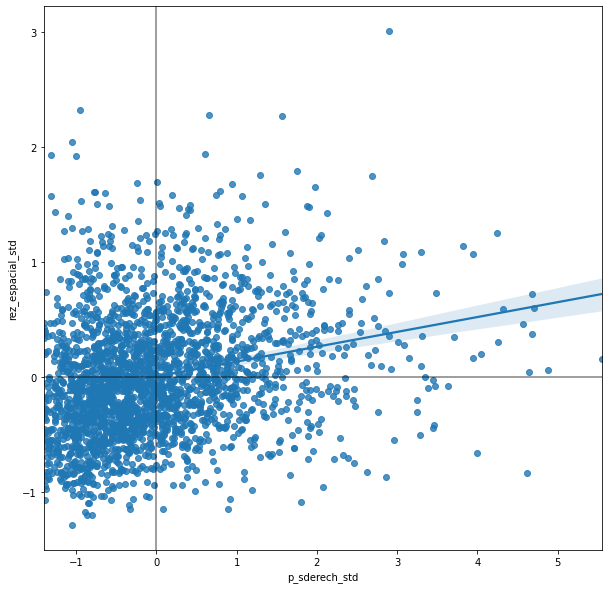

In [18]:
# Preparación de la Gráfica
fig, filas = plt.subplots(1, figsize = (10,10))

# Generación del Diagrama de Dispersión
sns.regplot(x = 'p_sderech_std' , y = 'rez_espacial_std', data = agebs)

# Adición de lineas horizontal y vertical
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)

# Muestra del resultado
plt.show()

La gráfica anterior muestra la relación entre la variable estandarizada (`p_sderech_std`) y su rezago espacial (`rez_espacial_std`) el cual, debido a la estandarización del Matriz de Pesos Espaciales, se puede interpretar como el promedio de la variable en su vecindad. Para facilitar la interpretación de la gráfica, también se incluye una Regresión Lineal, junto con sus intervalos de confianza; esta línea representa el mejor ajuste para el Diagrama de Despersión o, en otras palabras, cuál es la mejor manera de representar la relación entre las dos variables en una línea recta. Debido a que la línea proviene de una regresión, también puede incluirse una medida de la incertidumbre sobre la regresión en la forma de Intervalos de Confianza (el área sombreada alrededor de la línea).

La gráfica muestra una relacíon positiva entre ambas variables. Esto se asocia directamente con la presencia de una Autocorrelación Espacial *Positiva*: los valores similares tienden a encontrarse cercanos entre sí. Lo anterior significa que el *Patrón General* es que los valores altos se encuentran cercanos a los valores altos, y viceversa. De todas formas, esto no significa que ésta sea la única situacíon en el conjunto de datos; deben de exitir casos particulares en los que valores altos se encuentren rodeados de valores bajos, y lo contrario también es cierto. Lo que sí significa es que, si se tuviera que resumir el patrón principal de los datos en términos de qué tan agregados se encuentran valores similares, la mejor forma sería decir que se encuentran correlacionados positivamente y, por ende, agrupados en el espacio.

En el contexto de este ejemplo, esto puede ser interpretado como que las AGEB's donde existe un gran número de personas sin derechohabiencia a servicios públicos de salud se encuentran rodeadas por otras AGEB's donde ocurre el mismo fenómeno.

### I de Moran
El Gráfico de Moran es una herramienta excelente para explorar los datos y tener una buena idea de qué tanto se encuentran agregados los valores en el espacio. Sin embargo, debido a que se trata de una herramienta gráfica, resulta en ocasiones difícil el condensar cualquier conclusión de forma más concisa. Para estos casos, resulta útil encontrar un método estadístico que resuma las conclusiones a las que se pretende llegar; esto es exactamente lo que la I de Moran pretende hacer.

De la misma forma en la que la Media resume un elemeto crucial de la distribución de los valores en un contexto no espacial, la I de Moran también lo hace para un conjunto de datos con la componente espacial. Continuando con la comparación, puede pensarse en la Media como un único valor numérico que describe un Histograma o un Gráfico de Densidad de Kernel; de forma similar, la I de Moran captura mucha de la escencia del Gráfico de Moran. De hecho, inclusive existe una conección entre ambos: el valor de la I de Moran corresponde con la pendiente de la Regresíon Lineal presente en la gráfica.

Para calcular la I de Moran del conjunto de datos, se puede llamar directamente a una función de `PySAL`:

In [19]:
import esda.moran as esdaM
moran = esdaM.Moran(agebs['p_sderech'], m_reina)
moran

Cabe destacar como no es necesario utilizar la versión estandarizada de la variable en el comando anterior, pues no se producirá una representación visual.

La función anterior crea un objeto que contiene mucha más información que el propio estadístico aislado. Para recupear el valor de la I de Moran, puede recurrise a la propiedad `I` del objeto generado:

In [20]:
moran.I

0.12916538334944302

La otra información pertinente para la interpretación de la I de Moran se realaciona con la Inferencia Estadística: ¿Qué tan probable es que el patrón que se observa en el mapa y su I de Moran sean generado por un proceso completamente aleatorio? Si se considerara exactamente la misma variable, pero se distribuyera su ubicación al azar, ¿se obtendría un mapa con características similares?

Los detalles específicos del mecanismo para calcular esto rebasa el alcance de esta práctica, pero resulta importante saber que un valor lo suficientemente pequeño de *p-value* asociado a la I de Moran de un mapa permite rechazar la hipótesis de que el conjunto de datos se encuentra distribuido de forma aleatoria. En otras palabras, puede concluirse que los datos muestran un Patrón Espacial mayor al que se esperaría si los valores hubiesen sido localizados de forma aleatoria en el espacio.

El valor más confiable de *p-value* para la I de Moran puede ser encontrado a través del atributo `p_sim`:

In [21]:
moran.p_sim

0.001

Esta significancia es mucho menor que el 1% y, en términos generales, se consideraría que se trata de un estadístico significativo. Nuevamente, una explicación detallada del verdadero significado de esto y sus implicaciones rebasan el objetivo de la práctica, pero se pueden realizar algunas interpretaciones rápidas: lo que el 0.001 (0.1%) significa es que, si se generaran un enorme número de mapas con exactamente los mismos valores, pero distribuídos de formas diferentes, y se calculará la I de Moran para cada uno de estos mapas, sólo el 0.1% mostrarían un valor del estadístico mayor al que se está obteniendo de los datos reales, mientras que el resto de los mapas generados al azar tendrían un valor menor. Si se recuerda que el valor de la I de Moran puede ser interpretado como la pendiente del Gráfico de Moran, lo que se tiene es que, para este caso, el acomodo particular de los valores en el espacio para la variable de personas sin derechohabiencia se encuentra mucho más concentrado que si se intercambiaran la cantidad de personas entre todas las AGEB's de la CDMX, razón por la cual el estadístico se vuelve significativo.

Como un primer paso, el Análisis de Autocorrelación Global muestra que las observaciones guardan una correlación *positiva* entre sí en el espacio. En términos de la variable que se está analizando, puede empezarse a suponer que el espacio juega un papel importante en el valor que ésta adquirirá dentro de cada AGEB.
___
## Autocorrelación Espacial Local
La I de Moran es útil para resumir un conjunto de datos en un sólo valor que informa sobre su grado de agrupamiento (*Clustering*). Sin embargo, no es una medida apropiada para identificar las áreas dentro del mapa en las que ciertos valores se ubican; en otras palabras, la I de Moran permite determinar si los valores se encuentra agrupados en general, pero no informará sobre dónde se encuentran estos agrupamientos. 

Para este propósito, es necesario utilizar una medida *local* de la Autocorrelación Espacial. Las medidas locales consideran a cada una de las observaciones de un conjunto de datos y trabajan sobre ellas, al contrario de la generalidad de los datos, como hacen las medidas *globales*. Debido a esto, no son buenas para resumir la información de un mapa, pero si para obtener un mayor transfondo del mismo.

En esta práctica, se considerarán [Indicadores Locales de Asociación Espacial](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1538-4632.1995.tb00338.x) (LISA's, en inglés), una contraparte local de las medidas globales. En el corazón de este método se encuentra la clasificación de las observaciones de un conjunto de datos entre cuatro grupos derivados del Gráfico de Moran: valores altos rodeados por valores altos (HH), valores bajos rodeados por valores bajos (LL), valores altos rodeados de bajos (HL) y viceversa (LH). Cada uno de estos grupos son comúnmente llamados *Cuadrantes*; ilustrativamente, se pueden observar de la siguiente manera:

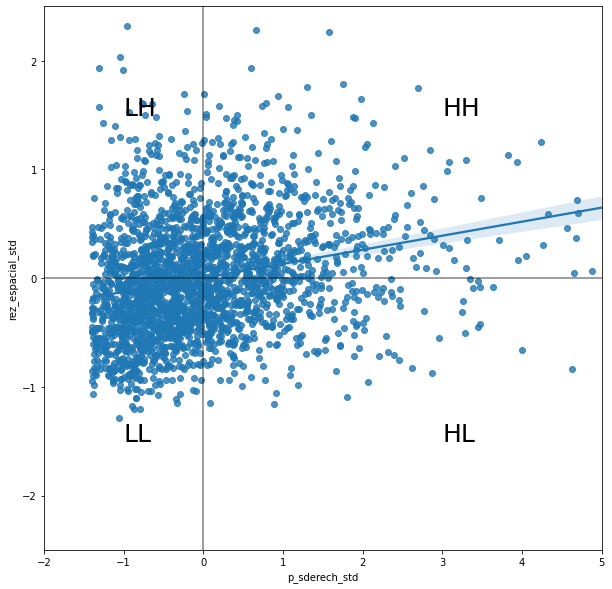

In [22]:
# Preparación de la Gráfica
fig , filas = plt.subplots(1, figsize = (10,10))

# Generación de la Gráfica
sns.regplot(x = 'p_sderech_std' , y = 'rez_espacial_std', data = agebs)

# Adición de Línas
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)

# Definición de límites según número de Desviaciones Estándar
filas.set_xlim(-2, 5)
filas.set_ylim(-2.5, 2.5)

# Adición de nombre de los cuadrantes
plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -1.5, "HL", fontsize=25)
plt.text(-1, 1.5, "LH", fontsize=25)
plt.text(-1, -1.5, "LL", fontsize=25)

# Gráfica Resultante
plt.show()

Hasta ahora se ha clasificado cada observación del conjunto de datos en función de su valor o el de sus vecinos; esto es sólo la mitad del trabajo de identificar las áreas con concentraciones inusuales de valores. Para saber la ubicación de cada uno de las aglomeraciones (clusters) *estadísticamente significativos* de cualquier tipo, primero es necesario comparar los datos reales con lo que se esperaría obtener con datos localizados aleatoriamente. Después de todo, por definición, toda observación será de algún tipo según lo observado en el Gráfico de Moran; sin embargo, lo que resulta de interés es saber la significancia de la concentración de estos valores.

Esto es exactamente para lo que los métodos LISA's fueron diseñados. Como ha ocurrido anteriormente, una descripción mucho más detallada del procedimiento estadístico involucrado rebasa el propósito de la práctica, pero se analizará un poco la lógica detrás del proceso. La idea central es el identificar casos en los que la comparación entre el valor de una observación y el promedio de sus vecinos es muy similar (HH y LL) o diferente (HL y LH) de lo que se esperaría obtener por mera suerte; el mecanismo para hacer esto es similar al existente en la I de Moran Global, pero aplicado para cada observación, resultando en tener tantas estadísticos como observaciones.

Los métodos LISA's son utilizados en muchos campos para encontrar agrupaciones de valores en el espacio. Son una herramienta bastante útil que permite obtener rápidamente áreas en las que los valores se encuentren concentrados, y proveen de evidencia *sugestiva* sobre el proceso que puede originar lo observado; debido a esto, resultan una herramienta clave en el análisis espacial. Ejemplos en los que los métodos LISA pueden ser de utilidad incluyen la identificación de aglomeraciones (clusters) espaciales de pobreza en una región, detección de enclaves étnicos, delineación de áreas con mucha o poca presencia de un fenónemo, entre muchos otros.

En Python, el cálculo de LISA's es bastante sencillo gracias a las facilidades de `PySAL`:

In [23]:
import libpysal
import numpy as np
np.random.seed(10)
w = libpysal.io.open(libpysal.examples.get_path("desmith.gal")).read()
ff = libpysal.io.open(libpysal.examples.get_path("desmith.txt"))
y = np.array(ff.by_col['z'])
#from esda.moran import Moran_Local
lm = esdaM.Moran_Local(y, w, transformation = "r", permutations = 99)
lm.q
#array([4, 4, 4, 2, 3, 3, 1, 4, 3, 3])
#lm.p_z_sim[0]
#0.24669152541631179
#lm = Moran_Local(y, w, transformation = "r", permutations = 99,                             geoda_quads=True)
#lm.q
#array([4, 4, 4, 3, 2, 2, 1, 4, 2, 2])

array([4, 4, 4, 2, 3, 3, 1, 4, 3, 3])

In [24]:
m_reina = pss.weights.Queen.from_shapefile(f + 'pob_sinderechohab.shp', idVariable = 'cvegeo')
m_torre = pss.weights.Rook.from_shapefile(f + 'pob_sinderechohab.shp', idVariable = 'cvegeo')

#m_reina = pss.weights.Queen.from_dataframe(agebs)
m_reina.transform = 'r'
m_reina.transform
m_torre.transform

C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There is 1 island with id: 090090015012A.
  warnings.warn(message)


('WARNING: ', '090090015012A', ' is an island (no neighbors)')


C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
 There is 1 island with id: 090090015012A.
  warnings.warn(message)


'O'

In [25]:
yy=agebs['p_sderech']
yy=np.array(yy.values)
yy=yy.reshape((len(yy),1))
yy

array([[ 389.],
       [ 323.],
       [ 448.],
       ...,
       [ 497.],
       [ 464.],
       [1529.]])

In [26]:
#lisa = esdaM.Moran_Local(agebs['p_sderech'].values , m_reina)
lisa = esdaM.Moran_Local(yy,m_reina)
#lisa = esdaM.Moran_Local(yy,m_torre,seed=1)

lisa

ValueError: cannot assign slice from input of different size

Lo único que se necesita es establecer la variable de interés (Personas sin Derechohabiencia, en este caso), y la Matriz de Pesos Espaciales que describe las vecindades de cada una de las observaciones del conjunto de datos.

Debido a su naturaleza intrínseca, observar los resultados numéricos de LISA no siempre resulta la manera más útil de aprovechar toda la información que pueden proporcionar. LISA implica calcular un estadístico para todas y cada una de las observaciones del conjunto de datos por lo que, si se tienen muchos de ellos, será difícil descifrar cualquier patrón. Como tal, lo que normalmente se hace es crear un mapa, llamado *Mapa de Clusters*, que extrae las observaciones significativas (aquellas que muy probablemente no derivaron de la aleatoriedad) y asignarles un color en particular según la categoría del cuadrante.

Todas las piezas necesarias para armar este mapa se encuentran contenidas en el objeto `lisa` creado en el comando anterior. Pero, para que el mapa sea más fácil de comprender, es conveniente retirarlos del objeto y colocarlos en la tabla principal:

In [ ]:
# Determinar si una observación es significativa o no
agebs['significativo'] = lisa.p_sim < 0.05

# Almacenar el cuadrante al cual pertenecen
agebs['cuadrante'] = lisa.q

De forma similar a como ocurre con la I de Moran Global, `PySAL` automáticamente calcula un *p-value* para cada LISA; debido a que no todas las observaciones son estadísticamente significativas, lo que se busca es identificar a éstas con un *p-value* lo suficientemente pequeño para asegurar que no fueron producto del azar. Tomando como significativos a todos los valores con un *p-value* menor al 5%, se crea la columna `significativo` que contiene `True` si el *p-value* de la observación satisface esa condición, y `False` si no es así. Esto puede ser verificado sencillamente:

In [ ]:
agebs['significativo'].head()

Y los primeros cinco *p-values* pueden ser obtenidos de la siguiente forma:

In [ ]:
lisa.p_sim[:5]

Debido a que todos los valores son menores a 0.05, todas son asignadas un `True` dentro de la tabla.

En términos del cuadrante al que corresponde cada observación, este puede ser verificado fácilmente pues forma parte del objeto `lisa` directamente:

In [ ]:
agebs['cuadrante'].head()

La correspondencia entre los números de la variable y el nombre de los cuadrantes es la siguiente:

* 1 - HH
* 2 - LH
* 3 - LL
* 4 - HL

Con estos dos elementos, `significativo` y `cuadrante`, es posible construir un *Mapa de Clusters* tradicional, combinando todo lo ya aprendido sobre la construcción de mapas en Python:

In [ ]:
fig , filas = plt.subplots(1 , figsize = (10,10))
agebs.plot(color = 'grey' , linewidth = 0.5 , ax = filas)

# AGEB's del tipo Alto-Alto (Rojo Oscuro)
hh = agebs.loc[(agebs['cuadrante'] == 1) & (agebs['significativo'] == True) , 'geometry']
hh.plot(ax = filas , color = 'red')

# AGEB's del tipo Bajo-Alto (Azul Claro)
ll = agebs.loc[(agebs['cuadrante'] == 3) & (agebs['significativo'] == True) , 'geometry']
ll.plot(ax = filas , color = 'blue')

# AGEB's del tipo Bajo-Bajo (Azul Oscuro)
lh = agebs.loc[(agebs['cuadrante'] == 2) & (agebs['significativo'] == True) , 'geometry']
lh.plot(ax = filas , color = '#83cef4')

# AGEB's del tipo Alto-Bajo (Rojo Claro)
hl = agebs.loc[(agebs['cuadrante'] == 4) & (agebs['significativo'] == True) , 'geometry']
hl.plot(ax = filas , color = '#e59696')

El mapa anterior muestra las AGEB's de la Ciudad de México y las colorea en función cómo han sido identificadas según los métodos LISA, únicamente si son considerados estadísticamente significativos por los mismos. De color rojo muy saturado se encuentran las AGEB's con números muy altos de Personas sin Derechohabiencia, que tienden a concentrarse en los límites de la ciudad; de color rojo pastel, aquellos que tienen una alta cantidad de esta población, pero que se encuetran en zonas donde éste no es el patrón buscado; de color azul, zonas donde hay una cantidad muy pequeña de personas sin derechohabiencia, que se concentran en el interior de la ciudad; por último, de azul pastel, las zonas donde esta población es pequeña, pero el patrón en la vecindad es que sea alta.

Para que los resultados obtenidos cobren sentido, es necesario relacionar lo observado con el objetivo del proyecto con el que se esté trabajando. Comúnmente, este tipo de análisis se realiza para comprobar, a través de cierta rigidez estadística, que la componente espacial tiene una influencia importante sobre los valores observados; en otras palabras, sería posible concluir a partir de las pruebas anteriores que el Número de Personas sin Derechohabiencia que se registren en un AGEB depende, de una forma u otra, de la ubicación del AGEB.

Claro está que esta conclusión no es completamente determinante, pues, dado que son datos obtenidos de situaciones reales, existen un sinnúmero de factores que pueden influir sobre la variable estudiada, y que no necesariamente se están considerando dentro del procedimiento. Sin embargo, la ventaja de los métodos anteriores es que ofrecen una base estadísticamente válida para continuar trabajando con otros métodos del Análisis Espacial, y así acercarse más al objetivo deseado.

#### Ejercicio Opcional
Genera un mapa similar al anterior, pero esta vez únicamente mostrando las AGEB's clasificadas como Alto-Alto (HH), ignorando cualquier otro Valor Atípico Espacial. ¿Qué es lo que se puede concluir?

#### Solución

No pude :c

___
## Para Practicar...
Replica todo el análisis anterior para alguna de las otras variables contenidas en el `ShapeFile` original, siendo:
* `p_nescu` - Población de 15 a 24 años que no asiste a la escuela
* `p_hacin` - Población que vive en Hacinamiento
* `p_analf` - Población de 15 años o más analfabeta

Para la variable que hayas escogido, realiza lo siguiente:
* Crea un Mapa de Coropletas.
* Obten la Matriz de Pesos Espaciales, utilizando el criterio (Contigüidad, Distancia, Bloques) que consideres más óptimo. Justifica la elección del criterio.
* Estandariza la variable elegida, y obten su rezago espacial.
* Crea la Gráfica de Moran
* Realiza un Análisis LISA y genera un mapa de los resultados obtenidos. Responde a la pregunta, ¿cuál es el patrón observado?

## Solución

### Crea un Mapa de Coropletas.

In [ ]:
# Preparación de la figura y sus filas
fig , filas = plt.subplots(1, figsize = (10,10))

# Gráfica del GeoDataFrame, generando un Mapa de Coropletas a través de 'scheme'
agebs.plot(ax = filas, column = 'p_nescu', scheme = 'fisherjenks' , cmap = 'YlGn', legend = True)

# Adición de título a la gráfica
fig.suptitle('Población de 15 a 24 años que no asiste a la escuela', size = 20)

# Mostrar la gráfica
plt.show()

### Obten la Matriz de Pesos Espaciales, utilizando el criterio (Contigüidad, Distancia, Bloques) que consideres más óptimo. Justifica la elección del criterio.

Se elige el metodo de contiguidad ya que la Contigüidad se define como las relaciones espaciales a través de la existencia de fronteras comúnes y creemos que hay relacion entre la posición espacial de una población y la educación de los jovenes entre 15 y 24 años. Usaremos el criterio Torre por ser un poco más robusto con las fronteras en cuanto a que no solo basta que compartan un vertice, si no todo un segmento, haciendo más cerrado el grupo de vecinos.

In [ ]:
m_torre = pss.weights.Rook.from_shapefile(f + 'pob_sinderechohab.shp', idVariable = 'cvegeo')
m_torre.transform = 'R'

### Estandariza la variable elegida, y obten su rezago espacial.

In [1]:
#Regazo no standar
agebs['rez_espacial'] = pss.weights.lag_spatial(m_torre , agebs['p_nescu'])

agebs[['p_nescu' , 'rez_espacial']].head()

#Regazo standar
agebs['p_nescu_std'] = (agebs['p_nescu'] - agebs['p_nescu'].mean()) / agebs['p_nescu'].std()
agebs.head()

agebs['rez_espacial_std'] = pss.weights.lag_spatial(m_torre , agebs['p_nescu_std'])
agebs.head()

NameError: name 'pss' is not defined

En la tabla anterior se puede ver el regazo de la variable antes y despues de estandarizarla

### Crea la Gráfica de Moran

In [ ]:
# Preparación de la Gráfica 
fig, filas = plt.subplots(1, figsize = (10,10))

# Generación del Diagrama de Dispersión
sns.regplot(x = 'p_nescu_std' , y = 'rez_espacial_std', data = agebs)

# Adición de lineas horizontal y vertical
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)

# Muestra del resultado
plt.show()

La gráfica anterior muestra la relación entre la variable estandarizada (p_nescu_std) y su rezago espacial (rez_espacial_std) el cual, debido a la estandarización del Matriz de Pesos Espaciales, se puede interpretar como el promedio de la variable en su vecindad.

La gráfica muestra una relacíon positiva entre ambas variables. Esto se asocia directamente con la presencia de una Autocorrelación Espacial Positiva: los valores similares tienden a encontrarse cercanos entre sí. 

**Esto puede ser interpretado como que las AGEB's donde existe un gran número de personas entre 15 a 24 años que no asiste a la escuela se encuentran rodeadas por otras AGEB's donde ocurre el mismo fenómeno.**

### Realiza un Análisis LISA y genera un mapa de los resultados obtenidos. Responde a la pregunta, ¿cuál es el patrón observado?

In [ ]:
import esda.moran as esdaM

lisa = esdaM.Moran_Local(agebs['p_nescu_std'].values , m_torre)
#Por más hrs que estuve intentando resolver esta parte del trabajo no pude obtener una solución

In [1]:
import pysal as ps

C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
ps.versions.installed #deberia ser otra 2.xxx

C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


{'libpysal': '4.3.0',
 'esda': '2.3.1',
 'giddy': '2.3.3',
 'segregation': '1.3.0',
 'pointpats': '2.2.0',
 'inequality': '1.0.0',
 'spaghetti': '1.5.3',
 'access': '1.1.2',
 'spreg': '1.1.2.post1',
 'spglm': '1.0.8',
 'spint': '1.0.7',
 'tobler': '0.4.0',
 'spvcm': '0.3.0',
 'splot': '1.1.3',
 'mapclassify': '2.3.0'}

In [2]:
ps.

AttributeError: module 'pysal' has no attribute 'versions'